In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
import random
import math, statistics
import numpy as np
from scipy.spatial import distance

In [2]:
class CaseAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, initial_wealth=10):
        super().__init__(unique_id, model)
        self.wealth = initial_wealth
        self.alt_wealth_calculation=0
        self.original_wealth=self.wealth
        self.memory = []
        self.action = 0
        self.result=0
        self.cases = []
        self.deflator_cases = []
        self.circumstances = []
        self.action_set=[0.25, 0.5, 0.75]
        
    def get_circumstance(self):
        if len(model.realized_interest_rate_list) <=2:
            p_2 = random.choice(range(0,1))
            p_1 = 1                  
            new_circumstance = (p_2-p_1)/p_1
        else:
            new_circumstance =  (model.realized_interest_rate_list[-1]- model.realized_interest_rate_list[-2])/model.realized_interest_rate_list[-2]
        return new_circumstance
        print( "new circumstance is", new_circumstance, ".")
        
    def get_wealth(self):
        wealth = self.wealth
        return wealth
    
    def choose_action(self):
        if not self.cases:
            choice = random.choice(self.action_set)
            
        else:
            best_choice = self.evaluate_actions()    
            choice=random.choice(best_choice)
        return choice    
         
    
    def evaluate_actions(self):                  #evaluate all the actions and choose the one which has highest CBU
        cbu_list = list()
        for action in self.action_set:
            all_action_cbu = []
            new = np.array([action,self.get_circumstance()])
                
           
            for case in self.deflator_cases: #<--- looping through memory for each action, accumulate data in all_action_cbu    
                old =np.array([case["action"], case["circumstance"]])
                if abs(action-case["action"]) > model.B/2: #<--- do not consider this case, out of bandwidth
                    pass # you don't need to do anything here
                    
                else: #<--- consider this case and add to all_action_cbu
                    similarity =1/math.exp(distance.euclidean(new,old))
                    single_case_cbu = similarity*(case["result"] - model.H)
                    all_action_cbu.append(single_case_cbu)
             
            # Now, we have gone through all memory, and evaluate it for this action
            if len(all_action_cbu) == 0 : # I have found NO relevant cases in memory (TODO: CHECK CODE)
                cbu = 0
            else: # I have found at least one relevant case
                cbu = sum(all_action_cbu)

            act_value = {"action":action, "value":cbu}
            cbu_list.append(act_value)
            # now we have act_value for this action
   
        best_value = max(cbu_list, key=(lambda x: x["value"]))
        #print("best_value is ",best_value)
        best_choices= []
    
      

        for act_value in cbu_list:
            if act_value["value"] == best_value["value"]:
                best_choices.append(act_value["action"])
                
        return best_choices
        print(best_choices,".")            
    
    def get_flow_utility(self):
        consumption = self.wealth*self.action
        flow_utility = math.log(consumption)   #calculate each agent's payoff
        return flow_utility
        
    #def get_continuation_utility(self):
    
    def update_case(self):
        values = i.cases.values()
        values_list = list(values)
        i.cases[k]["result"]=i.cases
        return cases
    
    def print(self):
        print("agent: ", self.unique_id, " wealth: ", self.wealth," original_wealth: ", self.original_wealth, 
              " alt wealth: ", self.alt_wealth_calculation , "ratio:", self.original_wealth / self.alt_wealth_calculation )
        

In [3]:
class CaseModel(Model):
    """A model with some number of agents."""
    def __init__(self, N=50, Bandwidth=0, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=.5, K0=None, initial_wealth=10, use_alt_wealth=False
                 , verbose=False):#(50,0.1,10,0.90,1,0.33,None,0.5)
        self.num_agents = N
        # Create agents
        self.schedule = RandomActivation(self)
        self.actions=[]
        self.all_capital = []
        self.all_consumption = []
        if K0 is not None:
            self.total_K = K0
        else:
            self.total_K = N * initial_wealth
        self.consumption_list = []
        self.capital_list = []
        self.total_C = 0
        self.results=[]
        self.wealths=[]
        
        self.verbose=verbose
        
        self.use_alt_wealth = use_alt_wealth
        
        self.realized_interest_rate = 0
        self.realized_interest_rate_list = []
        self.real_wage = 0
        self.real_wage_list = []
        self.total_output=0
        self.output_list = []
        self.agents=[] #ADP: have an agents vector directly in Model.
        self.tick=0    #ADP: keep track of time.
        self.H = H
        self.B = Bandwidth
        self.beta = beta
        self.action_set=[0.25, 0.5, 0.75]
        self.z = z
        self.alpha = alpha
        self.deflator=deflator
        self.delta=delta
          # Create agents
        for i in range(self.num_agents):
            a = CaseAgent(i, self, initial_wealth)
            self.schedule.add(a)
            self.agents.append(a)
        self.datacollector = DataCollector(
            model_reporters={"interest_rate": "realized_interest_rate",
                             "real_wage":"real_wage",
                            'GDP':"last_output", #'GDP':"total_output",
                             "capital":"total_K",
                            "consumption":"total_C"},
            agent_reporters={"Wealth": "wealth", "Result": "result", "Action": "action", "Cases":"cases"})
        
    def reset(self):
        self.actions = []
        self.all_capital=[]
        self.all_consumption=[]
        self.results = []
        
    def calculate_price(self):
        total_K=sum(self.all_capital)
        realized_interest_rate =self.z*self.alpha*(total_K**(self.alpha-1))
        
        if self.use_alt_wealth:
            realized_interest_rate = self.total_output / self.total_K - 1
        
        return realized_interest_rate
    
    def calculate_wage(self):
        total_K=sum(self.all_capital)
        real_wage =self.z*(1-self.alpha)*(total_K**self.alpha)
        return real_wage
    
    def get_output(self):
        total_K=sum(self.all_capital)
        total_output =self.z*(total_K**(self.alpha))
        return total_output
    
    def get_consumption(self):
        total_C=sum(self.all_consumption)
        return total_C
    
    def get_capital(self):
        total_K=sum(self.all_capital)
        return total_K
    
    def update_H(self):
        self.H = (self.H)*self.beta
        return self.H
    
    def initialize(self):
        
        for i in self.agents:
            i.action = random.choice(self.action_set)
            self.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            self.all_capital.append(i.current_capital)
        #print( "actions:", self.actions, ".") 
        #print( "all capital", self.all_capital, ".") 
        
    def step(self):
        '''Advance the model by one step.'''
        
        
        #self.schedule.step()
        
        
        self.reset() # this sets up the turn
        self.tick += 1 # ADP: iterate time.
        #previous_price = self.calculate_price()
        
        #save lags
        self.last_total_K = self.total_K
        self.last_output = self.total_output
        
        for i in self.agents:
            # loop where agents choose
            
            self.H = self.update_H()
            i.new_circumstance = i.get_circumstance()  #observe new circumstance
            
            #i.wealth = i.get_wealth()
            #print( "new circumstance:", i.new_circumstance, ".") 
            
            i.action = i.choose_action()
            #print( "choices:", i.evaluate_actions, ".") 
            #agents make predictions for each round "action"
           
            self.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            i.current_consumption = i.wealth*i.action
            
            self.all_capital.append(i.current_capital)
            self.all_consumption.append(i.current_consumption)
            
        
        #print("all past prices are:", self.realized_interest_rate_list)
        
        
        #
        self.realized_interest_rate = self.calculate_price() # must be based on current action
        
        
        self.real_wage = self.calculate_wage()        
        self.realized_interest_rate_list.append(self.realized_interest_rate)
        self.real_wage_list.append(self.real_wage)
        self.total_output = self.get_output()  
        self.output_list.append(self.total_output)
        self.total_C = self.get_consumption()
        self.total_K = self.get_capital()
        self.consumption_list.append(self.total_C)
        self.capital_list.append(self.total_K)
        if self.verbose:
            print( "price:", self.realized_interest_rate, ".") #model calculate the market price  "circumstance"

        
        
        for i in self.agents: 
            # loop where they get their payoffs
            
            i.result = i.get_flow_utility()                 #agents get their payoff for each round  "result"
            self.results.append(i.result)
            
            i.new_case = {"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.cases.append(i.new_case)
          
            i.deflator_case={"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.deflator_cases.append(i.deflator_case)
            for index in range(len(i.deflator_cases)):
                length=len(i.deflator_cases)
                i.deflator_cases[index]["result"]=i.deflator_cases[index]["result"]+self.delta**(length-index)*i.result
                
            #i.update_case()
            #print(i.cases[:3]) 
      
           
            #i.actions_chosen.append(i.prediction)
            i.wealth = i.current_capital*(1+self.realized_interest_rate)            #next period goods
            i.original_wealth=i.wealth
            
            i.alt_wealth_calculation= self.total_output * ( i.current_capital / self.total_K ) #<--- actual return
            
                # ( i.current_capital / self.total_K ) = my fraction of the capital I own.
                # total_K = not based on current output. 
            
            if self.use_alt_wealth:
                i.wealth=i.alt_wealth_calculation
            
        self.datacollector.collect(self)    
       
        
        if self.verbose:
            print( "Time:", self.tick, ".") 
        #print( "Model_choices:", self.actions, ".")  
        #print( "Model_results:", self.results, ".")
      
       
         
    def print(self): 
        # ADP: Give every object a "print" function.
     
        print( "my__prediction", self.actions, ".")
        print( "realized_price", self.realized_interest_rate, ".")
        
        for i in self.agents:
            i.print()

In [4]:
model = CaseModel(N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=.5,use_alt_wealth=True)

model.initialize()
for i in range(50):
    model.step()    

    #model.print()
import matplotlib.pyplot as plt



# For jupyter notebook add the following line:
%matplotlib inline
all_data = model.datacollector.get_model_vars_dataframe()


In [5]:
all_data[1:2]

,interest_rate,real_wage,GDP,capital,consumption
1,-0.975261,1.021273,6.184722,3.587139,2.597583


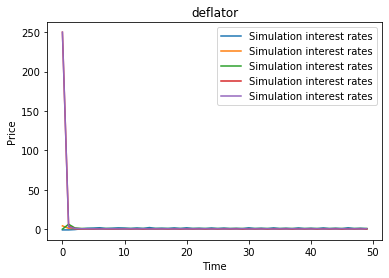

In [6]:
plt.figure()

plt.plot(all_data,label="Simulation interest rates")


plt.xlabel("Time")
plt.ylabel("Price")
plt.title("deflator")
#
plt.legend()

#model.datacollector.get_agent_vars_dataframe()

#plt.figure()
plt.savefig('deflator.png')

In [7]:
all_data.columns

Index(['interest_rate', 'real_wage', 'GDP', 'capital', 'consumption'], dtype='object')

In [8]:
def figfromdat(dat=None,name="default"):
    plt.figure()

    somedata=dat[10:50]
    plt.plot(somedata, label=somedata.columns)


    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("deflator")
    #
    plt.legend()

    #model.datacollector.get_agent_vars_dataframe()

    #plt.figure()
    plt.savefig(name+'deflator.png')


In [9]:
modelNoDefl = CaseModel(N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=0,use_alt_wealth=True)

modelNoDefl.initialize()
for i in range(50):
    modelNoDefl.step()    
    
data_NoDefl = modelNoDefl.datacollector.get_model_vars_dataframe()

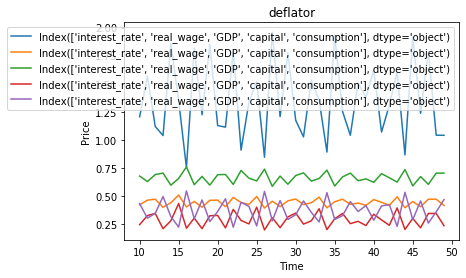

In [10]:
figfromdat(dat=data_NoDefl,name="NoDefl")

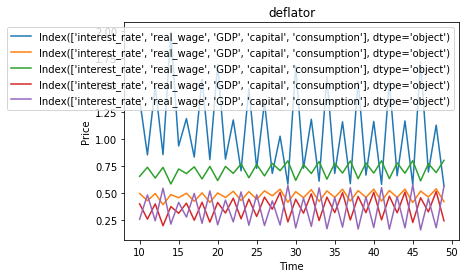

In [11]:
figfromdat(dat=all_data,name="Defl")

In [12]:
model.print()

my__prediction [0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5] .
realized_price 0.5634656755682543 .
agent:  0  wealth:  0.000296813981989077  original_wealth:  0.00017875165209855408  alt wealth:  0.000296813981989077 ratio: 0.6022346080217079
agent:  1  wealth:  0.0171157898656963  original_wealth:  0.010307721000749531  alt wealth:  0.0171157898656963 ratio: 0.6022346080217079
agent:  2  wealth:  0.05134736959708889  original_wealth:  0.030923163002248587  alt wealth:  0.05134736959708889 ratio: 0.6022346080217079
agent:  3  wealth:  0.0171157898656963  original_wealth:  0.010307721000749531  alt wealth:  0.0171157898656963 ratio: 0.6022346080217079
agent:  4  wealth:  0.00029681398198907696  original_wealth:  0.00017875165209855405  alt wealth:  0.0

In [13]:
model.step()
model.print()

my__prediction [0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25] .
realized_price 1.596107322201414 .
agent:  0  wealth:  0.0002473288470889223  original_wealth:  0.0003852804759868007  alt wealth:  0.0002473288470889223 ratio: 1.5577660289997657
agent:  1  wealth:  0.02139334144299869  original_wealth:  0.03332582054669619  alt wealth:  0.02139334144299869 ratio: 1.5577660289997657
agent:  2  wealth:  0.06418002432899607  original_wealth:  0.09997746164008856  alt wealth:  0.06418002432899607 ratio: 1.5577660289997657
agent:  3  wealth:  0.02139334144299869  original_wealth:  0.03332582054669619  alt wealth:  0.02139334144299869 ratio: 1.5577660289997657
agent:  4  wealth:  0.00024732884708892223  original_wealth:  0.00038528047598680064  alt wealth:  0.0002473288

In [14]:
import statistics as stat
import numpy as np
model.datacollector.get_agent_vars_dataframe()
data1 = model.datacollector.get_model_vars_dataframe()
data = data1[25:200]
gdp = data["GDP"]
consumption = data["consumption"]
wage = data["real_wage"]
capital = data["capital"]
i = data["interest_rate"]
data

#plt.plot(model.datacollector.get_agent_vars_dataframe())

,interest_rate,real_wage,GDP,capital,consumption
25,0.728045,0.440569,0.763827,0.280737,0.483090
26,1.342281,0.518774,0.657565,0.460621,0.196944
27,0.680968,0.473122,0.774290,0.348430,0.425859
28,1.026666,0.534644,0.706152,0.504662,0.201490
29,0.581211,0.412514,0.797977,0.229990,0.567987
30,1.677045,0.511576,0.615692,0.441525,0.174167
31,0.729339,0.456026,0.763546,0.311659,0.451887
32,1.183909,0.530101,0.680635,0.491778,0.188858
33,0.608848,0.420351,0.791195,0.243488,0.547707
34,1.576677,0.518860,0.627390,0.460853,0.166537


In [17]:
r_cy = np.corrcoef(gdp,consumption)
r_cy

array([[1.        , 0.95165524],
       [0.95165524, 1.        ]])

In [18]:
r_wy = np.corrcoef(gdp,wage)
r_wy

array([[ 1.        , -0.87442837],
       [-0.87442837,  1.        ]])

In [19]:
r_Ky = np.corrcoef(gdp,capital)
r_Ky

array([[ 1.        , -0.87114841],
       [-0.87114841,  1.        ]])

In [20]:
r_iy = np.corrcoef(gdp,i)
r_iy

array([[ 1.        , -0.99543566],
       [-0.99543566,  1.        ]])

In [21]:
y_std = np.std(gdp)
y_std

0.06844231622948638

In [22]:
c_std = np.std(consumption)
c_std

0.16829141893225738

In [23]:
K_std = np.std(capital)
K_std

0.10527838202462438

# current

In [25]:
def runmodel( delta=0 , H=10, verbose=False,t=50):
    model = CaseModel(N=50, Bandwidth=0, H=H, beta=.9,z=1,alpha=.33,deflator=None,delta=delta,use_alt_wealth=True, verbose=verbose)

    model.initialize()
    for i in range(t):
        model.step()    
        #model.print()
    import matplotlib.pyplot as plt



    # For jupyter notebook add the following line:
    %matplotlib inline
    thisdata = model.datacollector.get_model_vars_dataframe()
    return thisdata


In [26]:
def figfromdat(dat=None,name="default",t=50):
    plt.figure()

    somedata=dat[10:t]
    plt.plot(somedata, label=somedata.columns)


    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("deflator")
    #
    plt.legend()

    #model.datacollector.get_agent_vars_dataframe()

    #plt.figure()
    plt.savefig(name+'deflator.png')

In [27]:
def dataandfig( delta=0, verbose=False, name="default",t=50):
    thisdata=runmodel(delta=delta,verbose=verbose,t=t)
    figfromdat( dat=thisdata, name=name,t=t)

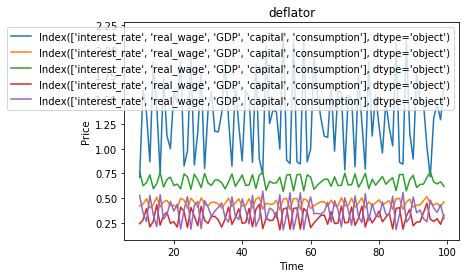

In [28]:
dataandfig(delta=.5,name="point5",t=100)

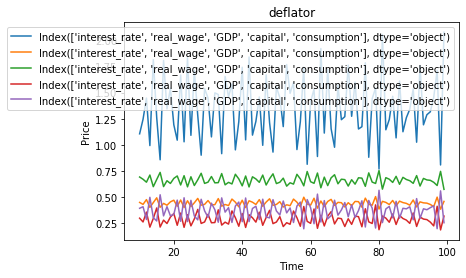

In [29]:
dataandfig(delta=0,name="zero",t=100)

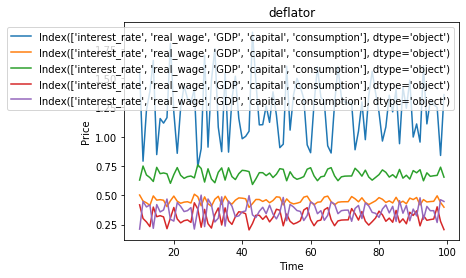

In [30]:
dataandfig(delta=.9,name="point9",t=100)

## next steps

variance in interest_rate:
    how does it vary with delta and H
    aggregate over runs

1) Run this code, tell us the outcome (commit to GitHub)

2) make a list of all variances and correlations of interest, modify this code to collect those


In [40]:
t=50
from scipy.stats import pearsonr

for thisH in np.linspace(0,10,11):
    for thisdelta in np.linspace(0,1,11):
        thesestats=[]
        corr_list =[]
        for runs in range(100):
            dat=runmodel( delta=thisdelta , H=thisH, verbose=False,t=t)
            thisdat=dat[10:t]
            thesestats.append(statistics.variance(thisdat["interest_rate"]))
            r_iy,_ = pearsonr(thisdat["GDP"],thisdat["interest_rate"])
            corr_list.append(r_iy)
#            for col in thisdat.columns:
#                thesestats.append(statistics.variance(thisdat[col])
        avg_interestrate_var=statistics.mean(thesestats)
        avg_corr = statistics.mean(corr_list)
        print("delta", thisdelta, "H", thisH, ": ","interest_rate", avg_interestrate_var,"correlation_iy",avg_corr)

delta 0.0 H 0.0 :  interest_rate 0.09493964614955554 correlation_iy -0.99558337179981
delta 0.1 H 0.0 :  interest_rate 0.09198953188938576 correlation_iy -0.9955184892341736
delta 0.2 H 0.0 :  interest_rate 0.09833942492435573 correlation_iy -0.9959455268653102
delta 0.30000000000000004 H 0.0 :  interest_rate 0.1189671951237278 correlation_iy -0.9949355847808802
delta 0.4 H 0.0 :  interest_rate 0.10711234451707323 correlation_iy -0.9950325520406579
delta 0.5 H 0.0 :  interest_rate 0.15722038893141468 correlation_iy -0.9934416849797658
delta 0.6000000000000001 H 0.0 :  interest_rate 0.23362087367700804 correlation_iy -0.9908247753449161
delta 0.7000000000000001 H 0.0 :  interest_rate 0.1848523423043794 correlation_iy -0.9900295483053787
delta 0.8 H 0.0 :  interest_rate 0.09547307153039428 correlation_iy -0.991132487603254
delta 0.9 H 0.0 :  interest_rate 0.08739622339534907 correlation_iy -0.9946030954463143
delta 1.0 H 0.0 :  interest_rate 0.1620787770553833 correlation_iy -0.985528929

delta 0.1 H 8.0 :  interest_rate 0.0920480821285674 correlation_iy -0.995580776173084
delta 0.2 H 8.0 :  interest_rate 0.09409827970829412 correlation_iy -0.9960711673710718
delta 0.30000000000000004 H 8.0 :  interest_rate 0.11666340672976248 correlation_iy -0.9951221854820711
delta 0.4 H 8.0 :  interest_rate 0.11244989845460249 correlation_iy -0.9947932563577925
delta 0.5 H 8.0 :  interest_rate 0.15652862707648882 correlation_iy -0.9933054229589631
delta 0.6000000000000001 H 8.0 :  interest_rate 0.23617322269504334 correlation_iy -0.9906045717723401
delta 0.7000000000000001 H 8.0 :  interest_rate 0.1838533662561679 correlation_iy -0.9901733611108748
delta 0.8 H 8.0 :  interest_rate 0.09905307930057144 correlation_iy -0.9910969824731124
delta 0.9 H 8.0 :  interest_rate 0.09037979905942667 correlation_iy -0.9945824650136048
delta 1.0 H 8.0 :  interest_rate 0.16954068104420536 correlation_iy -0.9854554657620417
delta 0.0 H 9.0 :  interest_rate 0.09260514931487414 correlation_iy -0.995781

In [63]:
print(np.linspace(0,1,11))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [76]:
statistics.mean(np.linspace(0,1,11))

0.5

In [37]:
from scipy.stats import pearsonr
x=[1,2,3]
y=[1,3,5]
a,_=pearsonr(x,y)
a

0.9999999999999998